In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential,layers

from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import matthews_corrcoef, make_scorer, accuracy_score, f1_score,roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold,train_test_split
from sklearn.preprocessing import StandardScaler

In [16]:
# load dataset
df = pd.read_csv("S1Data.csv")
X = df.drop(columns=['TIME',"Event"])
y = df['Event']

# train test split
X_train_val, X_test, y_train_val, y_test = train_test_split(X,y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val, test_size=0.25)

# normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


## Grid Search

In [44]:
def build_model(r=0.1, optimizer='adam'):
    model = Sequential()
    model.add(layers.Input(shape=(X_train_scaled.shape[1],)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate = r))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate =r))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate =r))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(model = build_model, verbose=0,r = 0.1)
custom_scorer = make_scorer(matthews_corrcoef)
param_grid = dict(epochs=[6,8,10,12], batch_size=[8, 16, 32], optimizer=['adam', 'rmsprop'], r = [0.1,0.2,0.3])
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=custom_scorer)
grid_result = grid.fit(X_train_scaled, y_train)

In [51]:
epoch = grid_result.best_params_['epochs']
batch = grid_result.best_params_['batch_size']
opt = grid_result.best_params_['optimizer']
rate= grid_result.best_params_['r']
print("The best parameters are:\n")
print(f"Epochs = {epoch}")
print(f"Batch size = {batch}")
print(f"Optimizer = {opt}")
print(f"Dropout rate = {rate}")

The best parameters are:

Epochs = 6
Batch size = 8
Optimizer = adam
Dropout rate = 0.3


## Best Model

In [ ]:
def build_model(rate=rate, optimizer='adam'):
    model = Sequential()
    model.add(layers.Input(shape=(X_train_scaled.shape[1],)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

best_ann = build_model(optimizer=opt)
hist = best_ann.fit(X_train_scaled,y_train,validation_data=(X_val_scaled,y_val), epochs=epoch, batch_size=batch)

Epoch 1/6
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5445 - loss: 0.6820 - val_accuracy: 0.7833 - val_loss: 0.5851
Epoch 2/6
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6530 - loss: 0.5948 - val_accuracy: 0.7667 - val_loss: 0.5279
Epoch 3/6
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6531 - loss: 0.5806 - val_accuracy: 0.7833 - val_loss: 0.5315
Epoch 4/6
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7131 - loss: 0.5220 - val_accuracy: 0.7833 - val_loss: 0.5175
Epoch 5/6
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7773 - loss: 0.5122 - val_accuracy: 0.7667 - val_loss: 0.5253
Epoch 6/6
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8008 - loss: 0.4366 - val_accuracy: 0.7500 - val_loss: 0.5200


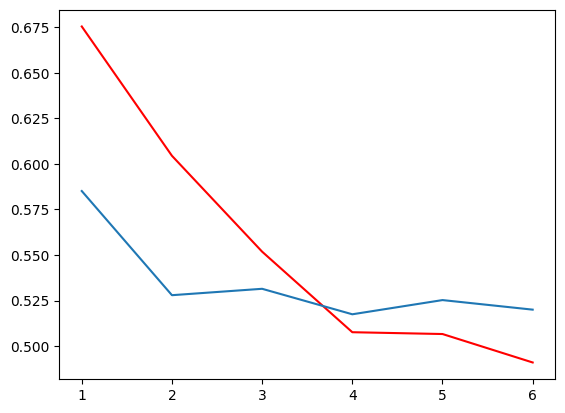

In [56]:
plt.plot([i for i in range(1,epoch+1)], hist.history['loss'], color = 'red')
plt.plot([i for i in range(1,epoch+1)], hist.history['val_loss'])


In [59]:
mcc = []
f1 = []
acc = []
auc = []
for i in range(100):
    best_ann = build_model(optimizer=opt)
    best_ann.fit(X_train_scaled,y_train,validation_data=(X_val_scaled,y_val), epochs=epoch, batch_size=batch, verbose = 0)
    y_prob = best_ann.predict(X_test_scaled,verbose=0)
    y_pred = (y_prob >=0.5).astype(int)
    mcc.append(matthews_corrcoef(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    acc.append(accuracy_score(y_test, y_pred))
    auc.append(roc_auc_score(y_test, y_prob))


In [64]:
print(f"Avgerage MCC score is {np.round(np.mean(mcc),6)}")
print(f"Avgerage F1 score is {np.round(np.mean(f1),6)}")
print(f"Avgerage Accuracy score is {np.round(np.mean(acc),6)}")
print(f"Avgerage ROC AUC score is {np.round(np.mean(auc),6)}")

Avgerage MCC score is 0.231397
Avgerage F1 score is 0.418209
Avgerage Accuracy score is 0.703167
Avgerage ROC AUC score is 0.722586


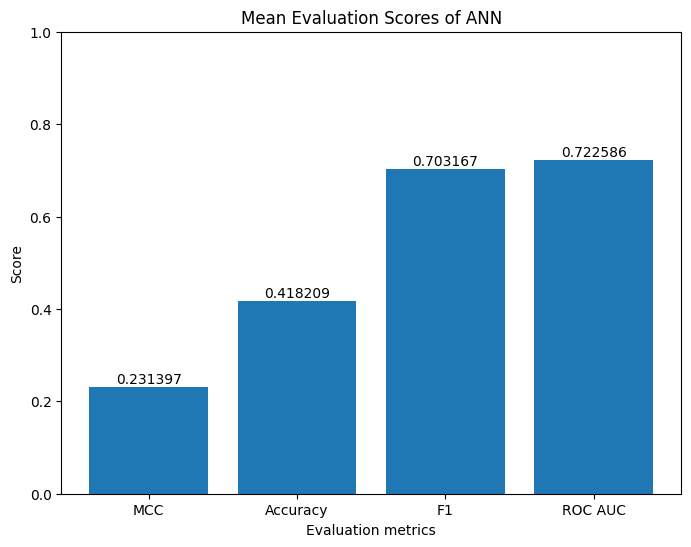

In [69]:
# plot scores
plt.figure(figsize=(8, 6))
scores = [np.round(np.mean(mcc),6),np.round(np.mean(f1),6),np.round(np.mean(acc),6),np.round(np.mean(auc),6)]
bars = plt.bar(['MCC', 'Accuracy', 'F1', 'ROC AUC'], scores)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
             f'{bar.get_height():.6f}', ha='center', va='bottom')
plt.title('Mean Evaluation Scores of ANN')
plt.xlabel('Evaluation metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()